In [69]:
from Bio import AlignIO
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import re
from tqdm import tqdm
from Bio import Align, Seq, SeqRecord
from Bio.Phylo import draw
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

In [110]:
alphabet = [c.upper() for c in ("a","c","d","e","f","g","h","i","k","l","m","n","p","q","r","s","t","v","w","y")]

def pc_id_to_query(msa,alphabet= alphabet, gaps_adjust = False, position_weights=None):
    msa_array = np.array(msa)

    N = len(msa)
    L = len(msa[0])
    nchar = len(alphabet)

    msa_array_binary = np.zeros((*msa_array.shape,nchar),dtype='int8')
    for i, a in enumerate(alphabet):
        msa_array_binary[:,:,i] = msa_array == a    
    msa_array_binary_reshape = np.reshape(msa_array_binary, (N, L * nchar)) 

    if position_weights is not None:
        # raise Exception('Not implemented yet!')
        # if len(position_weights) != L:
        #     raise Exception('Weights have different length')
        position_weights_char = np.repeat(position_weights, repeats=nchar)

        # Number of mismatches per residue
        # This counts 2 for a mismatch and 1 for a gap
        # Correct this later to just count mismatches / L 
        dist_to_query = cdist(
            msa_array_binary_reshape[0].reshape(1, L * nchar), 
            msa_array_binary_reshape, 
            metric='hamming',
            w = position_weights_char
            )
        
        n_gaps = (~msa_array_binary.any(axis=2) * position_weights).sum(axis=1)
        

    else:
        dist_to_query = cdist(
            msa_array_binary_reshape[0].reshape(1, L * nchar), 
            msa_array_binary_reshape, 
            metric='hamming'
            )
        n_gaps = (~msa_array_binary.any(axis=2)).sum(axis=1)
    dist_to_query = dist_to_query[0] * L * nchar
    
    # Adjust for number of gaps in aligned sequences
    if gaps_adjust:
        dist_to_query = dist_to_query - n_gaps
    
    # Adjust for doublecount of mismatches 
    dist_to_query = dist_to_query / 2

    # Final pc id
    pc_id = 1 - dist_to_query / L
    return pc_id

def sample_by_bin(bin_labels, bins, n_sample = 100):
    for bin in bins:
        bin_index = np.where(bin_labels == bin)[0]
        n_sample = min(n_sample, len(bin_index))
        bin_index_sample = list(np.random.choice(bin_index, n_sample, replace=False))
        yield bin_index_sample

def random_subsample_msa(msa, pc_id, N_sample, bins = [0.2,0.4,0.6,0.8,0.9], random_seed = 1):
    np.random.seed(random_seed)
    sample_index = np.random.choice(np.arange(len(msa)), N_sample, replace=False)
    msa_sample = Align.MultipleSeqAlignment([msa[int(i)] for i in sample_index])
    return msa_sample

def strat_subsample_msa(msa, pc_id, N_sample, bins = [0.2,0.4,0.6,0.8,0.9], random_seed = 1):
    np.random.seed(random_seed)
    N_sample_bin = N_sample // (len(bins) - 1)
    pc_id_binned = pd.cut(pc_id,bins = bins)
    sample_index = []
    for cat_sample_index in sample_by_bin(pc_id_binned, pc_id_binned.categories, N_sample_bin):
        sample_index.extend(cat_sample_index)        
    msa_sample = Align.MultipleSeqAlignment([msa[int(i)] for i in sample_index])
    return msa_sample

def get_tree(msa_sample, method = 'nj'):
    calculator = DistanceCalculator('blosum62')
    constructor = DistanceTreeConstructor(calculator, method)
    tree = constructor.build_tree(msa_sample)
    return tree


def get_consensus(msa_array):
    # one-hot encode residues 
    msa_array_binary = np.zeros((*msa_array.shape,20),dtype='bool')
    for i, a in enumerate(alphabet):
        msa_array_binary[:,:,i] = msa_array == a

    # find consensus columns
    consensus = (msa_array_binary.mean(axis=0)==1)

    # index into array of amino acids
    # represent lack of consensus with a gap 
    aa_array = np.repeat(np.array(alphabet + ['-']).reshape(1, 21), 263, axis=0)
    consensus_plus = np.concatenate((
        consensus, 
        ~consensus.any(axis=1).reshape((263, 1))
    ), axis=1) # L, 21
    return aa_array[consensus_plus]


def get_depth_index(tree):
    depths = tree.depths(unit_branch_lengths=True)
    df = pd.DataFrame(dict(
        name = [branch.name for branch in depths.keys()],
        depth = depths.values()
    ))
    df = df.sort_values('depth')
    return df


def lookup_by_names(tree):
    names = {}
    for clade in tree.find_clades():
        if clade.name:
            if clade.name in names:
                raise ValueError("Duplicate key: %s" % clade.name)
            names[clade.name] = clade
    return names


def get_consensus_tree(msa, tree, depth_index):    
    # lookup table for subsampled MSA
    lookup = lookup_by_names(tree)

    # Make an array for inner node consensus sequences
    L = len(msa[0])
    inner_nodes = [clade for clade in tree.find_clades() if not clade.is_terminal()]
    n_inner_nodes = len(inner_nodes)
    inner_node_names = [clade.name for clade in inner_nodes]
    consensus_sequences = np.concatenate((
        np.array(msa),
        np.zeros((n_inner_nodes,L), dtype='<U1')
    ))
    msa_ids = [sr.id for sr in msa]
    consensus_node_names = msa_ids + inner_node_names

    # iterate over possible depths, starting from longest branch
    # compute consensus sequences at each inner node
    # represent consensus gap or lack of consensus with a gap character
    for node in depth_index.sort_values('depth',ascending=False).name.values:
        if node.startswith('Inner'):
            child_ids = [clade.name for clade in lookup[node]]
            child_sequences = consensus_sequences[[consensus_node_names.index(child_id) for child_id in child_ids]]
            consensus_sequences[consensus_node_names.index(node)] = get_consensus(child_sequences)

    return consensus_sequences, consensus_node_names


def get_trace(msa, tree):
    # Index tree by depth
    depth_index = get_depth_index(tree)

    # Get consensus sequences for inner nodes
    consensus_sequences, consensus_node_names = get_consensus_tree(msa, tree, depth_index)

    # iterate over possible depths, starting from root
    # get all ids at this depth and filter for inner nodes
    # compare their consensus sequences
    # if more than 1 tree has a consensus character at position i and depth d
    # and position i has not had a trace level assigned yet
    # position i has trace level d
    trace = np.zeros(consensus_sequences.shape[1])
    max_depth = depth_index.depth.max()
    for depth in range(max_depth):
        ids_by_depth = depth_index[depth_index.depth==depth].name.values      
        ids_by_depth = [id for id in ids_by_depth if id.startswith('Inner')]
        consensus_by_depth = consensus_sequences[[consensus_node_names.index(id) for id in ids_by_depth]]
        trace[(trace<1) & ((consensus_by_depth != '-').sum(axis=0) > 1)] = depth

    trace[trace<1] = max_depth
    # Correct for error in JET implementation
    trace[trace< max_depth] -= 1
    trace_sig = (max_depth - trace) / max_depth
    return trace_sig

In [143]:
%time
from multiprocessing import Pool

alphabet = [c.upper() for c in ("a","c","d","e","f","g","h","i","k","l","m","n","p","q","r","s","t","v","w","y")]

msa_file = 'examples/blat_ecolx/aliBLAT.fasta'
msa = next(AlignIO.parse(msa_file,format='fasta'))
for sr in msa:
    sr.seq = re.sub('\.','-',str(sr.seq))
N = len(msa)
N_sample = round(np.sqrt(N))

# Get id to query sequence
pc_id = pc_id_to_query(msa)
print('Got PC id. Subsampling...')

trace_sigs = []

def get_subsample_trace(i):
    print('Subsample', i)
    msa_subsample = random_subsample_msa(msa, pc_id, N_sample, random_seed = i)
    # Get MSA and create tree 
    tree = get_tree(msa_subsample)

    # Get trace from MSA array
    trace_sig = get_trace(msa_subsample, tree)
    return msa_subsample, tree, trace_sig

n_workers = 10
n_tasks = 20
with Pool(n_workers) as p:
    subsample_traces = p.map(get_subsample_trace, range(n_tasks))

msa_subsamples = []
trees = []
traces = []
for msa_subsample, tree, trace_sig in subsample_traces:
    msa_subsamples.append(msa_subsample)
    trees.append(tree)
    traces.append(trace_sig)


mean_trace_sig = np.stack(traces).mean(axis=0)
std_trace_sig = np.stack(traces).std(axis=0)

df_trace = pd.DataFrame(dict(
    wt = msa[0], 
    pos = np.arange(1, len(msa[0])+1), 
    trace_mean = mean_trace_sig,
    trace_std= std_trace_sig
))

df_trace.to_csv('tests/BLAT_trace.csv')

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.34 µs
Got PC id. Subsampling...
SubsampleSubsampleSubsampleSubsampleSubsampleSubsampleSubsampleSubsampleSubsampleSubsample        0 2 314576
8
9







Subsample 10
Subsample 11
Subsample 12
Subsample 13
Subsample 14
Subsample 15
Subsample 16
Subsample 17
Subsample 18
Subsample 19


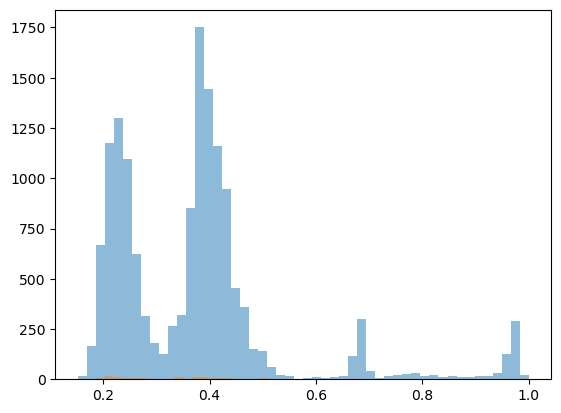

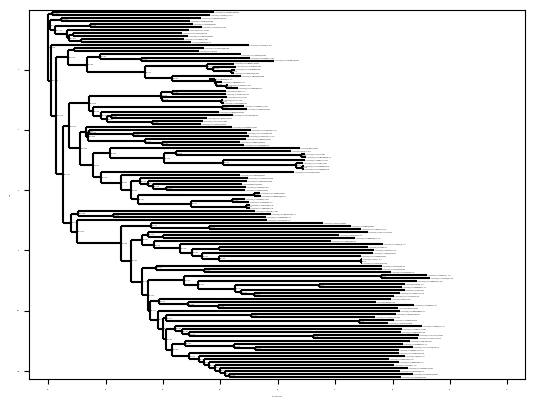

Inner114
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------G----------------------------------------------------
Inner102
--------A--E---GGR-GV---DT---------R--ERFP-CSTFK-L-A---L---D-G-E-L-R-------------P--------------LC-AA-T-SDN-AANL-L---G-PA--T---R--GD--T-LDR-EP-LN-----DPRDTTTP--M------L--G--L----R-QL--W-----TG--R-RAG-P--W-VGDKTGTG--G--ND----W-----P-----YLT----------A--A-V--------
Inner113
-------------------------------------------------------L--------------------L---SP--E------------C-A----SDN-A-N------G-P-----------D--T-LDR-E--LNEA---D-RDTT-----------------------------------------------------------------------------------------------------------
Inner88
-------L--LE--TGGRLGV-VLDT-T--SF--HR--ERFAMCSTFKALAAAC-LAR-D-G-EKLDR-----K--LL--SP--EK-VGG-MTV-ELC-AA-T-SDN-A-NLLL-SFGGP-GLT-WLR-IGD-TTRLDR-EP-LNEA--GDPRDTTTP-AM--TLGKL-LG--

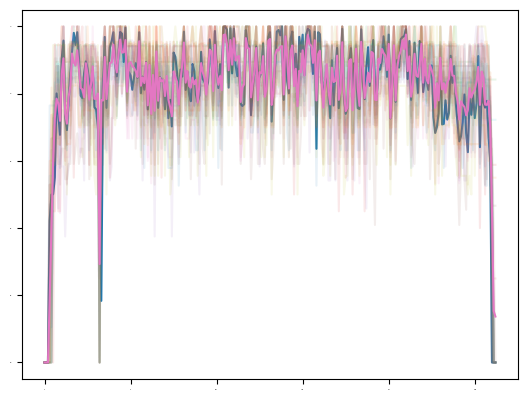

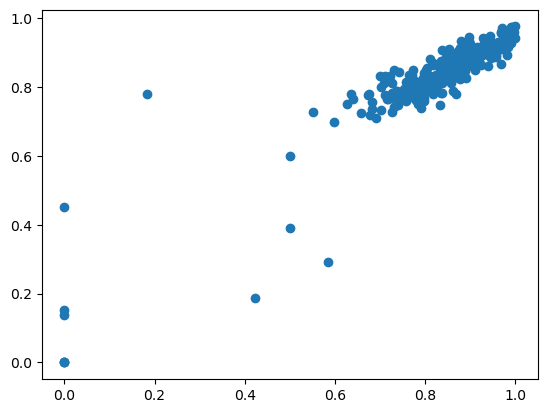

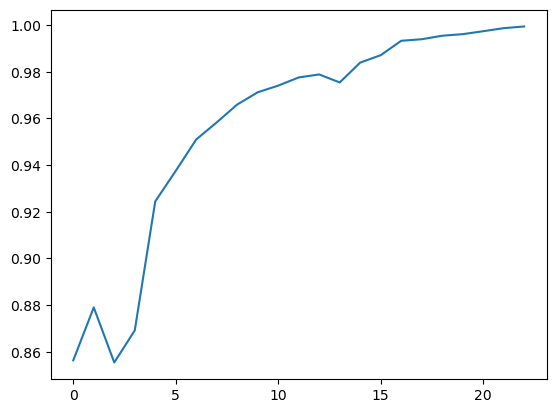

In [135]:
# diagnostic plots and results for subsampling



# check subsample diversity
msa = next(AlignIO.parse(msa_file,format='fasta'))

_ = plt.hist(pc_id, bins=50, alpha = 0.5, label='Full Alignment')
msa_subsample_w_query = Align.MultipleSeqAlignment([msa[0]] + [sr for sr in msa_subsamples[0]])

_ = plt.hist(pc_id_to_query(msa_subsample_w_query),bins=50, alpha = 0.5, label='Subsample')

trees[0].ladderize()
plt.rc('font', size=0) 
draw(trees[0])

# Check consensus sequences of tree
depth_index = get_depth_index(trees[0])
consensus_sequences, consensus_node_names = get_consensus_tree(msa_subsamples[0], trees[0], depth_index)

consensus_aln = []
for clade in trees[0].find_clades():
    sr = SeqRecord.SeqRecord(
        seq= Seq.Seq(''.join(consensus_sequences[consensus_node_names.index(clade.name)])),
        id = clade.name)
    consensus_aln.append(sr)

consensus_aln = Align.MultipleSeqAlignment(consensus_aln)
with open('tests/test_subsample_msa_consensus.fa','w') as fid:
    AlignIO.write([consensus_aln],fid,format='fasta')


# Check trace calculation at a chosen depth 
trace = np.zeros(consensus_sequences.shape[1])
max_depth = depth_index.depth.max()
for depth in range(max_depth):
    ids_by_depth = depth_index[depth_index.depth==depth].name.values      
    ids_by_depth = [id for id in ids_by_depth if id.startswith('Inner')]
    consensus_by_depth = consensus_sequences[[consensus_node_names.index(id) for id in ids_by_depth]]
    trace[(trace<1) & ((consensus_by_depth != '-').sum(axis=0) > 1)] = depth

trace[trace<1] = max_depth

# visualise a chosen depth
depth = 3
ids_by_depth = depth_index[depth_index.depth==depth].name.values      
ids_by_depth = [id for id in ids_by_depth if id.startswith('Inner')]
consensus_by_depth = consensus_sequences[[consensus_node_names.index(id) for id in ids_by_depth]]
for id in ids_by_depth:
    print(id)
    print(''.join(consensus_sequences[consensus_node_names.index(id)]))
print(''.join(np.where(trace == depth, 'X','-')))

# Check traces against JET results
jet_res_file = 'tests/BLAT_model/BLAT_jet.res'
df = pd.read_csv(jet_res_file,delim_whitespace=True)
plt.subplots()

plt.rcdefaults()
plt.plot(df.trace)
for trace_sig in traces:
    plt.plot(trace_sig, alpha = 0.1)

plt.plot(mean_trace_sig)
plt.subplots()
from scipy import stats
plt.scatter(df.trace, mean_trace_sig)

stats.spearmanr(df.trace, mean_trace_sig)


# check for convergence to mean value
corr = []
for i in range(2,len(traces)):
    mean_trace_sig_partial = np.stack(traces[:i]).mean(axis=0)
    corr.append(stats.spearmanr(mean_trace_sig, mean_trace_sig_partial)[0])

plt.subplots()
plt.plot(corr)

if max(corr) > 0.99:
    iter_thresh = min([i+1 for i in range(len(corr)) if corr[i]>0.99])
    print(f'99% correlation to mean value after {iter_thresh} iterations')
else:
    print(f'Has not converged after {len(traces)} iterations')

In [100]:
alphabet = [c.upper() for c in ("a","c","d","e","f","g","h","i","k","l","m","n","p","q","r","s","t","v","w","y")]

coarsegrained_alphabet = [
    'IMVL',
    'FWY',
    'G',
    'P',
    'CAST',
    'NHQED',
    'RK'
]

def predict_gemme(
        msa, 
        trace,
        thresh = 5, 
        alpha = 0.6,
        alphabet = alphabet,
        coarsegrained_alphabet = coarsegrained_alphabet
        ):
    msa_array = np.array(msa)
    N, L = msa_array.shape
    nchar = len(alphabet)

    msa_array_binary = np.zeros((N, L, nchar),dtype='bool')
    for i, aa in enumerate(alphabet):
        msa_array_binary[:,:,i] = msa_array == aa

    aa_counts = msa_array_binary.sum(axis=0)
    aa_counts_pseudo = np.maximum(aa_counts, 1)
    wt_counts = aa_counts[msa_array_binary[0]]
    ind_pred = np.log(aa_counts_pseudo / wt_counts.reshape(L, 1))


    msa_array_binary_reshape = np.reshape(msa_array_binary, (N, L * nchar)) 
    position_weights = trace**2
    position_weights_char = np.repeat(position_weights, repeats=nchar)

    msa_array_weighted_positions = msa_array_binary_reshape * position_weights_char
    sim  = msa_array_weighted_positions @ msa_array_binary_reshape[0] 
    max_sim = (np.ones(L) * position_weights).sum()  
    d_evol = max_sim - sim

    # find all distances to query
    seq, pos, aa = np.where(msa_array_binary)   
    max_dist = d_evol.max()
    epi = np.ones((N, L, nchar)) * (max_dist)
    epi[seq, pos, aa] = d_evol[seq]

    # Minimum distance to query
    epi_min = epi[1:].min(axis=0) 
    epi_secondmin = np.partition(epi, 1, axis=0)[1]
    epi_min_combi = np.where(
        epi_secondmin - epi_min > thresh,
        epi_secondmin, epi_min
    )
    
    epi_pred = np.select(
        condlist = [
            msa_array_binary[0],
            aa_counts<=1,
            aa_counts>1
        ],
        choicelist=[
            0,
            -100,# * 1.15, # don't like this but it works - could use NA
            epi_min_combi            
        ]
    )
    
    # Some bizarre normalisation 
    epi_pred_norm = epi_pred / np.sum(trace**2) 
    epi_pred_norm[epi_pred_norm < 0] = 1
    #epi_pred = np.nan_to_num(epi_pred,nan=1)

    
    # the actual normalisation 
    norm_epi = epi_pred / epi_pred.max()
    norm_epi[norm_epi < 0] = 1
    norm_epi = -norm_epi * trace.reshape((L, 1))

    # This is sensible thank Jesus
    norm_ind = ind_pred * trace.reshape((L, 1))

    # Weird ass reduced alphabet calculation
    nchar_reduced = len(coarsegrained_alphabet)
    msa_array_binary_reduced = np.zeros((N, L, nchar_reduced),dtype=bool)
    for i, aa_set in enumerate(coarsegrained_alphabet):
        msa_array_binary_reduced[:,:,i] = np.isin(msa_array, list(aa_set))
    aa_counts_reduced = msa_array_binary_reduced.sum(axis=0)
    aa_counts_pseudo_reduced = np.maximum(aa_counts_reduced, 1)
    wt_counts_reduced = aa_counts_reduced[msa_array_binary_reduced[0]]
    ind_pred_reduced = np.log(aa_counts_pseudo_reduced / wt_counts_reduced.reshape(L, 1))
    converter = np.zeros((nchar_reduced, nchar))
    for i, aa_set in enumerate(coarsegrained_alphabet):
        converter[i, :] = np.isin(np.array(alphabet), list(aa_set))
    ind_pred_reduced = ind_pred_reduced @ converter

    # combine 
    norm_epi_combine = epi_pred / epi_pred.max()
    norm_epi_combine[norm_epi_combine < 0] = 1
    norm_factor = -np.log(aa_counts.sum(axis=1).max())
    alpha = 0.6
    combi = alpha * norm_epi_combine * norm_factor + (1 - alpha) * ind_pred_reduced    
    norm_combi = combi * trace.reshape((L, 1))

    df = pd.DataFrame(dict(
        wt = msa_array[0].repeat(nchar),
        mut = np.tile(alphabet, L),
        pos = (np.arange(L) + 1).repeat(nchar),
        combi = norm_combi.reshape(L * nchar),
        norm_epi = norm_epi.reshape(L * nchar),
        norm_ind = norm_ind.reshape(L * nchar),
        epi = epi_pred_norm.reshape(L * nchar),
        ind = ind_pred.reshape(L * nchar),
    ))
    return df, d_evol

In [101]:
#predict_tracecalc = predict_gemme(msa, mean_trace_sig)
msa_file = 'tests/BLAT_model/BLAT_A.fasta'
msa = next(AlignIO.parse(msa_file,format='fasta'))
jet_res_file = 'tests/BLAT_model/BLAT_jet.res'
jet_trace = pd.read_csv(jet_res_file,delim_whitespace=True)
predict_tracejet, d_evol = predict_gemme(msa, jet_trace.trace.values)

In [124]:
from scipy import stats
gemme_predictions_tidy = pd.read_csv('tests/BLAT_model/model/BLAT_predictions.csv',index_col=0)
compare = gemme_predictions_tidy.merge(predict_tracejet, on = ['wt','pos','mut'])
print(compare[['combi_x','combi_y']].corr().iloc[0,1])
print(compare[['norm_epi_x','norm_epi_y']].corr().iloc[0,1])
print(compare[['norm_ind_x','norm_ind_y']].corr().iloc[0,1])
print(compare[['epi_x','epi_y']].corr().iloc[0,1])
print(compare[['ind_x','ind_y']].corr().iloc[0,1])
d_evol_gemme = pd.read_csv('tests/BLAT_model/model/BLAT_evolDist.mat',delim_whitespace=True).V1.values
print(np.max(d_evol[1:]-d_evol_gemme))


0.9999999999999999
1.0
1.0
1.0
1.0000000000000002
1.1368683772161603e-13


combi    0.618557
Name: vmax, dtype: float64


/tmp/ipykernel_19389/447725758.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(corr.index.map(nice_labels), rotation=45)


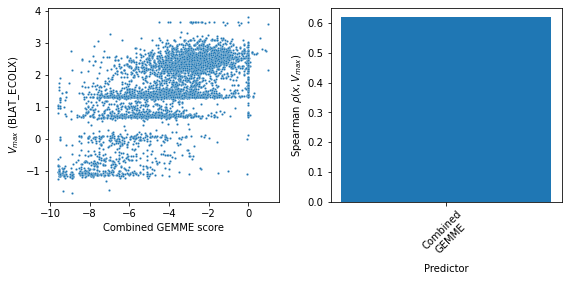

In [127]:
import seaborn as sns
offset = 23
holder = predict_tracejet.copy()
holder['pos'] = holder.pos + offset
holder['mutant'] = holder.wt + holder.pos.astype(str) + holder.mut

dms_data = pd.read_csv('./examples/blat_ecolx/BLAT_ECOLX_Ranganathan2015.csv',index_col=0)
dms_data = dms_data[['mutant','km','vmax']]
dms_data_w_gemme = dms_data.merge(holder)

fig, ax = plt.subplots(1,2, figsize=(8, 4))
sns.scatterplot(
    data = dms_data_w_gemme, 
    x = 'combi', y = 'vmax',
    ax = ax[0], s=5
)
ax[0].set_xlabel('Combined GEMME score')
ax[0].set_ylabel(r'$V_{max}$ (BLAT_ECOLX)')
corr = dms_data_w_gemme[['vmax','combi']].corr(method='spearman')['vmax'].iloc[1:]
print(corr)
ax[1].bar(x = corr.index, height= np.abs(corr.values))
nice_labels = {
    'combi':'Combined\nGEMME',
    'norm_epi':'Normalised\nepistatic',
    'norm_ind':'Normalised\nindependent',
    'epi':'Epistatic',
    'ind':'Independent'
}

ax[1].set_xticklabels(corr.index.map(nice_labels), rotation=45)
ax[1].set_xlabel('Predictor')
ax[1].set_ylabel(r'Spearman $\rho (x, V_{max})$')
plt.tight_layout()

(array([2656., 2855., 4506., 2923.,  433.,  186.,  512.,   68.,    8.,
         635.]),
 array([0.17490494, 0.25741445, 0.33992395, 0.42243346, 0.50494297,
        0.58745247, 0.66996198, 0.75247148, 0.83498099, 0.91749049,
        1.        ]),
 <BarContainer object of 10 artists>)

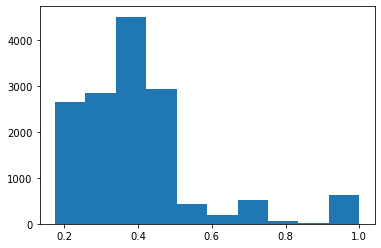

In [629]:
## Weighted pairwise ID of whole MSA - how viable is this?

def weighted_id(msa_file, jet_res_file, max_seqs = max_seqs, mode='query', alphabet=alphabet):
    msa = list(AlignIO.parse(msa_file,format='fasta'))
    trace = pd.read_csv(jet_res_file,delim_whitespace=True)

    msa_ids = [sr.id for sr in list(msa[0])]
    msa_seqs = [sr.seq for sr in list(msa[0])]

    N = len(msa_seqs)
    L = len(msa_seqs[0])
    nchar = len(alphabet)

    msa_array = np.zeros((N,L),dtype='<U1')
    for i, seq in enumerate(msa_seqs):
        msa_array[i, :] = list(seq)

    msa_array[~np.isin(msa_array,alphabet)] = '-'
    msa_array_binary = np.zeros((*msa_array.shape,20),dtype='int8')

    for i, a in enumerate(alphabet):
        msa_array_binary[:,:,i] = msa_array == a

    position_weights = trace.trace.values ** 2
    assert position_weights.shape[0] == L


    msa_array_binary_reshape = np.reshape(msa_array_binary, (N, L * nchar))
    msa_array_weighted = msa_array_binary_reshape * position_weights.repeat(nchar)

    if mode == 'query':
        query = msa_array_weighted[0].reshape(1, L * nchar)
        distmat = cdist(query, msa_array_weighted[1:max_seqs], metric='cityblock')
        df = pd.DataFrame(dict(
            id1 = msa_ids[0],
            id2 = msa_ids[1:max_seqs],
            dist=distmat.squeeze()
        ))
    elif mode == 'pairwise':
        distmat = cdist(msa_array_weighted[:max_seqs], msa_array_weighted[:max_seqs], metric='cityblock')
        r, c = np.triu_indices(max_seqs, 1, max_seqs)
        df = pd.DataFrame(dict(
            id1 = [msa_ids[r_] for r_ in r],
            id2 = [msa_ids[c_] for c_ in c],
            dist=distmat[r,c]
        ))
    return df

max_seqs = 1000

msa_file = 'tests/BLAT_model/BLAT_A.fasta'
jet_res_file = 'tests/BLAT_model/BLAT_jet.res'

weighted_id(msa_file, jet_res_file, 100, mode='query')
weighted_id(msa_file, jet_res_file, 100, mode='pairwise')